In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_set = "/content/drive/MyDrive/Data/"

In [ ]:
%cd /content/drive/MyDrive/Data/

/content/drive/MyDrive/Data


In [ ]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=5e3e2a17ef6098da53dd8b3d81b26810303beb58d64c608fb53a4d722f618ba8
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
import os
import librosa
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import scipy.io.wavfile as wav
from tempfile import TemporaryFile
from sklearn.model_selection import train_test_split
from python_speech_features import mfcc
import random
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import pandas as pd
import tensorflow as tf
import pickle
import math
from tensorflow import keras
import scipy
from google.colab import drive
from collections import Counter
import json
import heapq
import re
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import collections

In [ ]:
genres=os.listdir("/content/drive/MyDrive/Data/genres_original")

In [ ]:
print(genres)

['rock', 'metal', 'jazz', 'hiphop', 'disco', 'reggae', 'blues', 'classical', 'country', 'pop']


In [ ]:
file_length=[]
for genre in genres:
  print(len(os.listdir("/content/drive/MyDrive/Data/genres_original/"+genre)))
  file_length.append(len(os.listdir("/content/drive/MyDrive/Data/genres_original/"+genre)))

100
100
99
100
100
100
100
100
100
100


In [ ]:
df = pd.DataFrame({'genre': np.array(genres), '# of samples': file_length})

In [ ]:
df

,genre,# of samples
0,rock,100
1,metal,100
2,jazz,99
3,hiphop,100
4,disco,100
5,reggae,100
6,blues,100
7,classical,100
8,country,100
9,pop,100


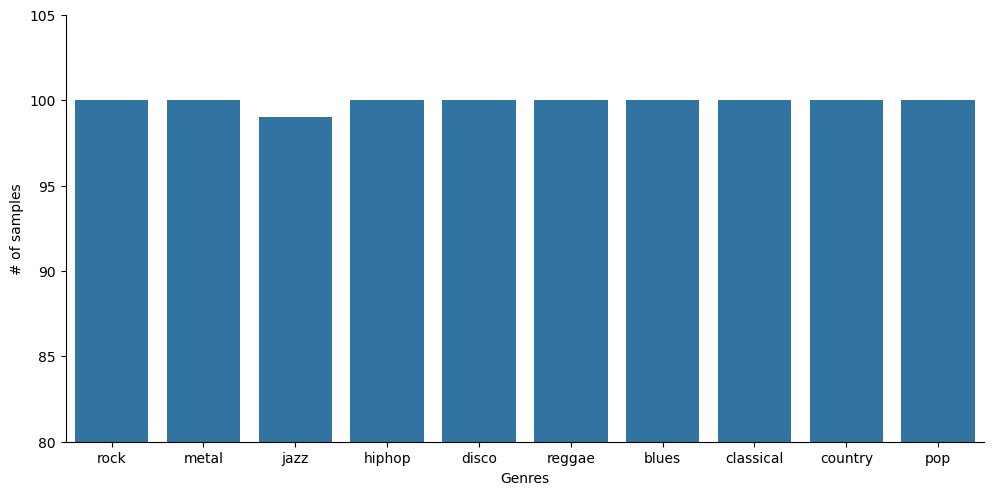

In [ ]:
import seaborn as sns
sns.catplot(x="genre", y="# of samples", kind='bar',data=df,height=5, aspect=2)
plt.xlabel("Genres")
plt.ylabel("# of samples")
plt.ylim(80, None)
plt.show()

In [ ]:
import os

# Ensure the parent directory exists
parent_dir = "/content/drive/MyDrive/Data/Data_Augmented/"
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# Create subdirectories for each genre
for genre in genres:
    genre_dir = os.path.join(parent_dir, genre)
    try:
        os.mkdir(genre_dir)
    except FileExistsError:
        print(f"Directory '{genre_dir}' already exists.")


Directory '/content/drive/MyDrive/Data/Data_Augmented/rock' already exists.
Directory '/content/drive/MyDrive/Data/Data_Augmented/metal' already exists.
Directory '/content/drive/MyDrive/Data/Data_Augmented/jazz' already exists.
Directory '/content/drive/MyDrive/Data/Data_Augmented/hiphop' already exists.
Directory '/content/drive/MyDrive/Data/Data_Augmented/disco' already exists.
Directory '/content/drive/MyDrive/Data/Data_Augmented/reggae' already exists.
Directory '/content/drive/MyDrive/Data/Data_Augmented/blues' already exists.
Directory '/content/drive/MyDrive/Data/Data_Augmented/classical' already exists.
Directory '/content/drive/MyDrive/Data/Data_Augmented/country' already exists.
Directory '/content/drive/MyDrive/Data/Data_Augmented/pop' already exists.


In [ ]:
import soundfile as sf

In [ ]:
!pip install librosa

In [ ]:
import os
import librosa
import soundfile as sf
import audioread

output_dir = '/content/drive/MyDrive/Data/Data_Augmented/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for genre in genres:
    for file in os.listdir('/content/drive/MyDrive/Data/genres_original/' + genre):
        try:
            audio, sr = sf.read('/content/drive/MyDrive/Data/genres_original/' + genre + '/' + file)
        except Exception as e:
            # If soundfile fails, try using audioread
            try:
                with audioread.audio_open('/content/drive/MyDrive/Data/genres_original/' + genre + '/' + file) as f:
                    audio = f.read()
                    sr = f.samplerate
            except Exception as e:
                print(f"Error loading file {file}: {e}")
                continue

        # Get number of samples for 10 seconds
        buffer = 10 * sr
        samples_total = len(audio)
        samples_wrote = 0
        counter = 1
        audio = audio[:buffer * 10]

        while samples_wrote < samples_total:
            if buffer > (samples_total - samples_wrote):
                buffer = samples_total - samples_wrote

            block = audio[samples_wrote : (samples_wrote + buffer)]
            out_filename = os.path.join(output_dir, genre, file[:-4] + "_split_" + str(counter))

            try:
                sf.write(out_filename + '.wav', block, sr)
            except Exception as e:
                print(f"Error writing file {out_filename}.wav: {e}")
                break

#file_genre+file_name+segment_number

            counter += 1
            samples_wrote += buffer


Error writing file /content/drive/MyDrive/Data/Data_Augmented/metal/metal.00092_split_1.wav: Error opening '/content/drive/MyDrive/Data/Data_Augmented/metal/metal.00092_split_1.wav': System error.


In [ ]:
len(os.listdir("/content/drive/MyDrive/Data/Data_Augmented/disco"))

399

In [ ]:
genres

['rock',
 'metal',
 'jazz',
 'hiphop',
 'disco',
 'reggae',
 'blues',
 'classical',
 'country',
 'pop']

In [ ]:
file_length=[]
for genre in genres:
  file_length.append(len(os.listdir("/content/drive/MyDrive/Data/Data_Augmented/"+genre)))

In [ ]:
df = pd.DataFrame({'genre': np.array(genres), '# of samples': file_length})

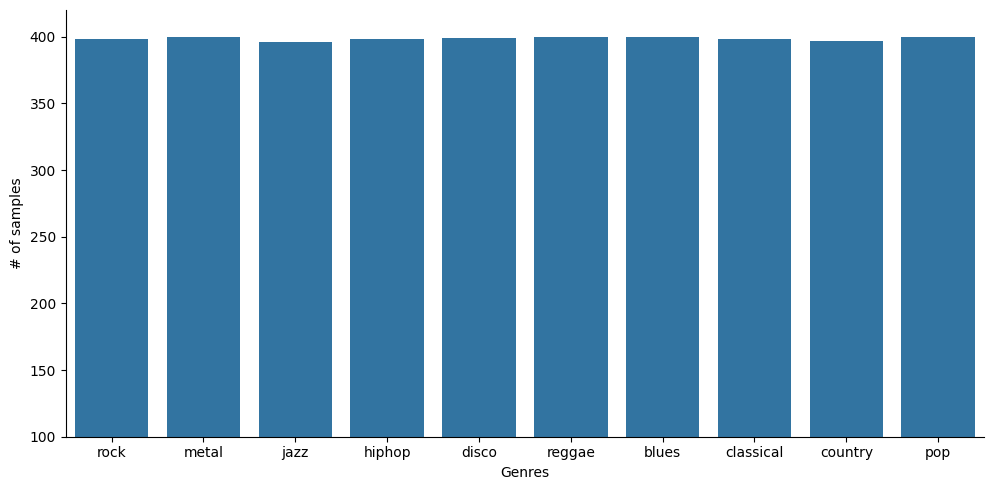

In [ ]:
import seaborn as sns
sns.catplot(x="genre", y="# of samples", kind='bar',data=df,height=5, aspect=2)
plt.xlabel("Genres")
plt.ylabel("# of samples")
plt.ylim(100, None)
plt.show()

In [ ]:
mfcc_cols_mean=['mfcc_'+str(i)+'_mean' for i in range(1,21)] #20-No. of MFCCs being extracted as feature from audio data
mfcc_cols_var=['mfcc_'+str(i)+'_var' for i in range(1,21)]
cols=mfcc_cols_mean+mfcc_cols_var+['spec_centroid_mean','spec_centroid_variance','spec_rolloff_mean','spec_rolloff_var','spectral bandwidth','tempo','rms_mean','genre']

In [ ]:
cols

['mfcc_1_mean',
 'mfcc_2_mean',
 'mfcc_3_mean',
 'mfcc_4_mean',
 'mfcc_5_mean',
 'mfcc_6_mean',
 'mfcc_7_mean',
 'mfcc_8_mean',
 'mfcc_9_mean',
 'mfcc_10_mean',
 'mfcc_11_mean',
 'mfcc_12_mean',
 'mfcc_13_mean',
 'mfcc_14_mean',
 'mfcc_15_mean',
 'mfcc_16_mean',
 'mfcc_17_mean',
 'mfcc_18_mean',
 'mfcc_19_mean',
 'mfcc_20_mean',
 'mfcc_1_var',
 'mfcc_2_var',
 'mfcc_3_var',
 'mfcc_4_var',
 'mfcc_5_var',
 'mfcc_6_var',
 'mfcc_7_var',
 'mfcc_8_var',
 'mfcc_9_var',
 'mfcc_10_var',
 'mfcc_11_var',
 'mfcc_12_var',
 'mfcc_13_var',
 'mfcc_14_var',
 'mfcc_15_var',
 'mfcc_16_var',
 'mfcc_17_var',
 'mfcc_18_var',
 'mfcc_19_var',
 'mfcc_20_var',
 'spec_centroid_mean',
 'spec_centroid_variance',
 'spec_rolloff_mean',
 'spec_rolloff_var',
 'spectral bandwidth',
 'tempo',
 'rms_mean',
 'genre']

In [ ]:
len(cols)

48

In [ ]:
directory = "/content/drive/MyDrive/Data/Data_Augmented"
F_feat = []

for z, genre in enumerate(genres, start=1):
    genre_d = os.path.join(directory, genre)
    for file in os.listdir(genre_d):
        if file.endswith(".wav"):
          file_path = os.path.join(genre_d, file)
          y, sr = librosa.load(file_path)
          mfcc_features = librosa.feature.mfcc(y=y, sr=sr,n_mels=128, n_mfcc=20)
          mfcc_mean = np.mean(mfcc_features, axis=1)
          mfcc_variance=np.var(mfcc_features,axis=1)
          # print('mfcc_mean',mfcc_mean)
          # print('mfcc_var',mfcc_variance)
          spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
          spec_centroid_mean=np.mean(spec_centroid,axis=1)
          spec_centroid_var=np.var(spec_centroid,axis=1)
          # print('spec_centroid_mean',spec_centroid_mean)
          # print('spec_centroid_var',spec_centroid_var)
          spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
          spec_rolloff_mean=np.mean(spec_rolloff,axis=1)
          spec_rolloff_var=np.var(spec_rolloff,axis=1)
          # print('spec_rolloff_mean',spec_rolloff_mean)
          # print('spec_rolloff_var',spec_rolloff_var)
          #spectral bandwidth
          spectral_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
          spectral_bw_mean=np.mean(spectral_bw,axis=1)
          # print("spectral_bandwidth",spectral_bw_mean)
          #temp0
          tempo = librosa.beat.tempo(y=y, sr=sr)
          # print("tempo",tempo)
          #loudness
          rms = librosa.feature.rms(y=y)
          rms_mean=np.mean(rms,axis=1)
          # print("rms_mean",rms_mean)
          X_vals_array=np.concatenate([mfcc_mean,mfcc_variance,spec_centroid_mean,spec_centroid_var,spec_rolloff_mean,spec_rolloff_var,spectral_bw_mean,tempo,rms_mean,[z]])
          # c_v = np.cov(mfcc_features)
          F_feat.append(X_vals_array)

df=pd.DataFrame(np.array(F_feat),columns=cols)

<ipython-input-24-2930d4208b4b>:30: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=y, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=294
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=4
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=176
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=480
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length

In [ ]:
df.shape

(3986, 48)

In [ ]:
df.to_csv('music_features.csv')

In [ ]:
df['genre'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Data/music_features.csv',index_col=False)

In [ ]:
df.head()

,Unnamed: 0,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,mfcc_19_var,mfcc_20_var,spec_centroid_mean,spec_centroid_variance,spec_rolloff_mean,spec_rolloff_var,spectral bandwidth,tempo,rms_mean,genre
0,0,-67.351311,146.204636,-53.354309,29.547867,-10.435096,21.296473,-24.711758,18.076807,-14.858020,...,34.171490,33.112514,1606.286848,108047.021500,3030.785850,704574.986651,1663.580446,99.384014,0.191822,1.0
1,1,-59.788864,148.161469,-54.337208,31.344435,-7.829246,19.267509,-26.013477,19.408634,-15.480832,...,27.395849,35.688072,1591.311417,126778.259712,2992.790488,653087.501875,1657.018013,99.384014,0.208456,1.0
2,2,-71.136703,164.052444,-53.134018,1.990108,7.219751,-12.426991,-18.091373,-2.741980,-4.764368,...,0.000000,0.000000,1424.295935,0.000000,2217.919922,0.000000,1421.521832,117.453835,0.106319,1.0
3,3,-60.468910,167.319382,-57.875553,23.385683,-2.472706,12.046634,-17.265020,17.127127,-7.572169,...,24.097521,21.861414,1427.784039,82168.426887,2584.309122,397189.499177,1455.683948,99.384014,0.210308,1.0
4,4,-0.416056,139.353989,-44.673450,27.494558,-20.540031,33.256783,-21.571201,18.777691,-20.615158,...,15.409591,18.337385,1753.930232,31008.513361,3464.097847,243503.449368,1869.159177,112.347147,0.268146,1.0


In [ ]:
df=df.iloc[:,1:]

In [ ]:
df.describe()

,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,...,mfcc_19_var,mfcc_20_var,spec_centroid_mean,spec_centroid_variance,spec_rolloff_mean,spec_rolloff_var,spectral bandwidth,tempo,rms_mean,genre
count,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,...,3986.000000,3986.000000,3986.000000,3.986000e+03,3986.000000,3.986000e+03,3986.000000,3986.000000,3986.000000,3986.000000
mean,-161.378976,96.896899,-9.363187,32.219459,-0.691473,12.380684,-4.317946,8.757311,-6.233996,6.777609,...,47.371850,49.971592,2308.059826,3.418675e+05,4743.891563,1.336474e+06,2303.953064,120.562229,0.107238,5.501756
std,110.966074,36.212323,22.976143,19.197328,12.927826,13.329457,10.679114,11.017857,9.040313,8.728680,...,44.419475,49.837052,870.910130,4.095635e+05,1768.050847,1.473731e+06,527.893178,18.699559,0.074009,2.872466
min,-1131.370972,-97.530579,-96.176956,-65.992523,-55.920959,-48.220638,-45.250446,-33.480232,-38.579163,-23.254135,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,61.523438,0.000000,1.000000
25%,-224.304928,72.121197,-25.614864,18.529601,-9.914323,2.720208,-12.644783,0.760300,-12.853093,0.488732,...,18.113341,17.654510,1658.734834,2.365480e+04,3434.545898,1.043134e+05,1969.048151,112.347147,0.044216,3.000000
50%,-139.216232,96.657467,-11.426023,32.367828,0.248363,12.058965,-3.810445,7.938178,-6.208483,6.363704,...,42.314304,42.418592,2241.452868,2.088630e+05,4722.416301,9.026585e+05,2279.476514,117.453835,0.102096,6.000000
75%,-79.050745,120.193943,6.175398,46.468456,8.739353,23.002346,3.701650,17.517951,0.416080,13.681952,...,65.950901,68.380478,2822.949287,4.843520e+05,5819.085849,1.958058e+06,2672.191739,129.199219,0.156263,8.000000
max,106.943085,233.001633,75.754791,83.337151,42.122543,49.285908,33.447731,53.953762,26.816826,37.845589,...,560.703064,712.592163,8374.446420,3.347463e+06,10400.537109,9.884046e+06,3850.839325,287.109375,0.428984,10.000000


<Figure size 2000x2000 with 0 Axes>

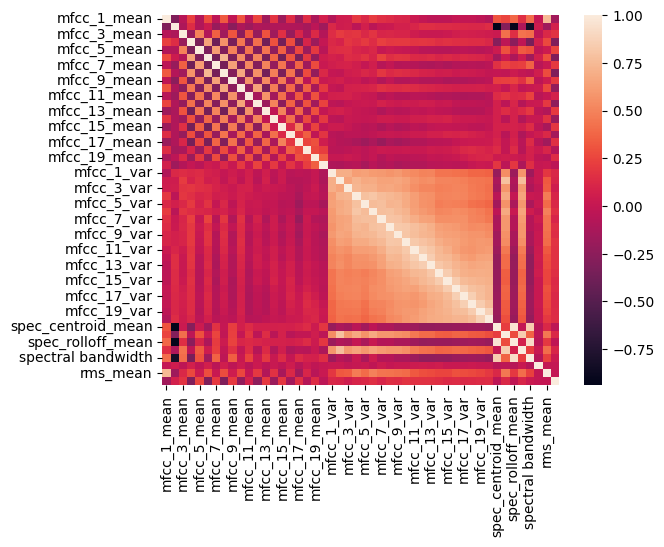

<Figure size 2000x2000 with 0 Axes>

In [ ]:
sns.heatmap(df.corr());
plt.figure(figsize=(20, 20))

In [ ]:
df.corr()

,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,...,mfcc_19_var,mfcc_20_var,spec_centroid_mean,spec_centroid_variance,spec_rolloff_mean,spec_rolloff_var,spectral bandwidth,tempo,rms_mean,genre
mfcc_1_mean,1.000000,-0.315269,-0.059288,0.223919,-0.086960,0.269786,-0.035942,0.332424,-0.023901,0.308741,...,-0.035659,-0.083974,0.306960,0.247714,0.386493,0.158081,0.404750,-0.002683,0.750296,-0.159739
mfcc_2_mean,-0.315269,1.000000,-0.105750,0.143557,-0.083069,0.032973,-0.201300,-0.078949,-0.261682,-0.109582,...,0.113562,0.138090,-0.935684,-0.288095,-0.918348,-0.103461,-0.835599,0.042033,-0.176130,0.070622
mfcc_3_mean,-0.059288,-0.105750,1.000000,-0.200603,0.489614,-0.082300,0.357169,-0.162728,0.304504,-0.249680,...,0.056382,0.043466,0.030787,0.414876,0.148952,0.430538,0.406322,-0.031980,0.119198,0.172425
mfcc_4_mean,0.223919,0.143557,-0.200603,1.000000,-0.323705,0.639657,-0.384729,0.564219,-0.340898,0.444574,...,0.139628,0.113180,-0.277966,-0.033421,-0.261256,-0.021230,-0.339251,0.071167,0.263099,-0.306182
mfcc_5_mean,-0.086960,-0.083069,0.489614,-0.323705,1.000000,-0.321206,0.612976,-0.307067,0.490011,-0.295307,...,-0.059620,-0.043419,0.032277,0.289669,0.100015,0.328473,0.292291,-0.024803,0.034528,0.250651
mfcc_6_mean,0.269786,0.032973,-0.082300,0.639657,-0.321206,1.000000,-0.365853,0.733945,-0.325869,0.544819,...,0.105227,0.064102,-0.142858,0.025585,-0.108445,0.044987,-0.160650,0.069914,0.286352,-0.312710
mfcc_7_mean,-0.035942,-0.201300,0.357169,-0.384729,0.612976,-0.365853,1.000000,-0.352746,0.630874,-0.310845,...,-0.069353,-0.050682,0.167623,0.247980,0.213054,0.223495,0.358713,-0.046050,0.014888,0.198646
mfcc_8_mean,0.332424,-0.078949,-0.162728,0.564219,-0.307067,0.733945,-0.352746,1.000000,-0.291730,0.664034,...,0.023353,-0.009972,-0.001216,-0.017086,0.035424,-0.006810,-0.035416,0.058626,0.281652,-0.312731
mfcc_9_mean,-0.023901,-0.261682,0.304504,-0.340898,0.490011,-0.325869,0.630874,-0.291730,1.000000,-0.252064,...,-0.064282,-0.039991,0.220253,0.226629,0.237198,0.166230,0.346401,-0.035307,0.043770,0.201892
mfcc_10_mean,0.308741,-0.109582,-0.249680,0.444574,-0.295307,0.544819,-0.310845,0.664034,-0.252064,1.000000,...,0.084314,0.059824,0.068282,-0.000369,0.106260,-0.013218,0.014760,0.033929,0.254703,-0.222801


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc=StandardScaler()

In [ ]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [ ]:
X.shape

(3986, 47)

In [ ]:
y=np.array(y)

In [ ]:
#KNN

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_onehot = ohe.fit_transform(y.reshape(-1, 1)).toarray()

In [ ]:
y_onehot.shape

(3986, 10)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

In [ ]:
sc.fit(X_train)

StandardScaler()

In [ ]:
X_train_scaled=sc.transform(X_train)
X_test_scaled=sc.transform(X_test)

In [ ]:
nearest_neighbors=[3,5,7]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
models=[]

In [ ]:
X_train.shape

(3188, 47)

In [ ]:
for i in nearest_neighbors:
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train_scaled,y_train)
  cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=10)
  dictionary={'neighbors':i,'cross validation score':np.mean(cv_scores)}
  models.append(dictionary)

In [ ]:
models

[{'neighbors': 3, 'cross validation score': 0.602887364208119},
 {'neighbors': 5, 'cross validation score': 0.5310601131681157},
 {'neighbors': 7, 'cross validation score': 0.4899686520376176}]

In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=3)
knn_final.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
accuracy_score(y_test,knn_final.predict(X_test_scaled))

0.6666666666666666

In [ ]:
#SVM

In [ ]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sc.fit(X_train)
X_train_scaled=sc.transform(X_train)
X_test_scaled=sc.transform(X_test)
print(X_train_scaled.shape)

(3188, 47)


In [ ]:
from sklearn.svm import SVC

In [ ]:
Cs=[0.1,0.5,1,3,5,10]
kernels=["linear", "poly", "rbf", "sigmoid"]
degrees=[1,3,5]
models=[]
for c in Cs:
  for kernel in kernels:
      if kernel=='poly':
        for degree in degrees:
          print(c,kernel,degree)
          svc = SVC(C=c,kernel=kernel,degree=degree)
          # svc.fit(X_train_scaled,y_train)
          cv_scores = cross_val_score(svc, X_train_scaled, y_train, cv=5)
          # y_predict=knn.predict(X_test_scaled)
          dictionary={'c':c,'kernel':kernel,'degree':degree,'cross validation score':np.mean(cv_scores)}
          models.append(dictionary)
      else:
        print(c,kernel)
        svc = SVC(C=c,kernel=kernel)
        # svc.fit(X_train_scaled,y_train)
        cv_scores = cross_val_score(svc, X_train_scaled, y_train, cv=5)
        # y_predict=knn.predict(X_test_scaled)
        dictionary={'c':c,'kernel':kernel,'cross validation score':np.mean(cv_scores)}
        models.append(dictionary)


0.1 linear
0.1 poly 1
0.1 poly 3
0.1 poly 5
0.1 rbf
0.1 sigmoid
0.5 linear
0.5 poly 1
0.5 poly 3
0.5 poly 5
0.5 rbf
0.5 sigmoid
1 linear
1 poly 1
1 poly 3
1 poly 5
1 rbf
1 sigmoid
3 linear
3 poly 1
3 poly 3
3 poly 5
3 rbf
3 sigmoid
5 linear
5 poly 1
5 poly 3
5 poly 5
5 rbf
5 sigmoid
10 linear
10 poly 1
10 poly 3
10 poly 5
10 rbf
10 sigmoid


In [ ]:
for model in models:
  print(model)

{'c': 0.1, 'kernel': 'linear', 'cross validation score': 0.6126110342859112}
{'c': 0.1, 'kernel': 'poly', 'degree': 1, 'cross validation score': 0.48400515740417216}
{'c': 0.1, 'kernel': 'poly', 'degree': 3, 'cross validation score': 0.38832891246684353}
{'c': 0.1, 'kernel': 'poly', 'degree': 5, 'cross validation score': 0.30050589804284383}
{'c': 0.1, 'kernel': 'rbf', 'cross validation score': 0.5084634577245415}
{'c': 0.1, 'kernel': 'sigmoid', 'cross validation score': 0.4360127557171892}
{'c': 0.5, 'kernel': 'linear', 'cross validation score': 0.6094747616915105}
{'c': 0.5, 'kernel': 'poly', 'degree': 1, 'cross validation score': 0.5668154505592928}
{'c': 0.5, 'kernel': 'poly', 'degree': 3, 'cross validation score': 0.5498693424801799}
{'c': 0.5, 'kernel': 'poly', 'degree': 5, 'cross validation score': 0.4106002372012224}
{'c': 0.5, 'kernel': 'rbf', 'cross validation score': 0.6292259464673258}
{'c': 0.5, 'kernel': 'sigmoid', 'cross validation score': 0.4278445692238796}
{'c': 1, 'k

In [ ]:
svm_final = SVC(C=10,kernel="rbf")
svm_final.fit(X_train_scaled,y_train)

SVC(C=10)

In [ ]:
accuracy_score(y_test,svm_final.predict(X_test_scaled))

0.7556390977443609

In [ ]:
#Random Forest Analysis

In [ ]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sc.fit(X_train)
X_train_scaled=sc.transform(X_train)
X_test_scaled=sc.transform(X_test)
print(X_train_scaled.shape)

(3188, 47)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
n_estimators=[5,10,20,100,150,200]
max_depths=[10,20,50,100]
models=[]
for n in n_estimators:
  for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=n,max_depth=max_depth)
    cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)
    dictionary={'n_estimator':n,'max_depth':max_depth,'cross validation score':np.mean(cv_scores)}
    models.append(dictionary)

In [ ]:
for model in models:
  print(model)

{'n_estimator': 5, 'max_depth': 10, 'cross validation score': 0.5181887078438804}
{'n_estimator': 5, 'max_depth': 20, 'cross validation score': 0.5269671215484023}
{'n_estimator': 5, 'max_depth': 50, 'cross validation score': 0.5304232713099709}
{'n_estimator': 5, 'max_depth': 100, 'cross validation score': 0.532945871862128}
{'n_estimator': 10, 'max_depth': 10, 'cross validation score': 0.5843757227993681}
{'n_estimator': 10, 'max_depth': 20, 'cross validation score': 0.5796700836109704}
{'n_estimator': 10, 'max_depth': 50, 'cross validation score': 0.5941083546994876}
{'n_estimator': 10, 'max_depth': 100, 'cross validation score': 0.5875183929371122}
{'n_estimator': 20, 'max_depth': 10, 'cross validation score': 0.6226438586044497}
{'n_estimator': 20, 'max_depth': 20, 'cross validation score': 0.6336185981506179}
{'n_estimator': 20, 'max_depth': 50, 'cross validation score': 0.6282835391209776}
{'n_estimator': 20, 'max_depth': 100, 'cross validation score': 0.6364482807832561}
{'n_es

In [ ]:
rf_final=RandomForestClassifier(n_estimators=200,max_depth=20)
rf_final.fit( X_train_scaled, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200)

In [ ]:
accuracy_score(y_test,rf_final.predict(X_test_scaled))

0.6942355889724311

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.49122807017543857


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)

In [ ]:
accuracy1 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy1)

Accuracy: 0.6516290726817042


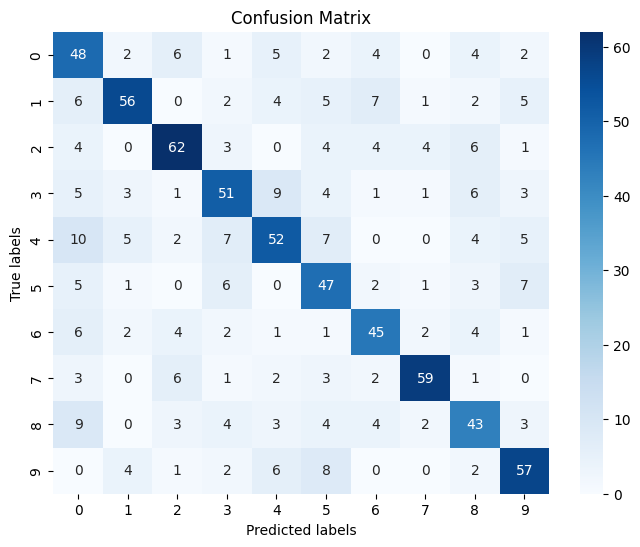

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true contains the true labels and y_pred contains the predicted labels

# Calculate the confusion matrix
cm = confusion_matrix(y_pred, y_test)

# Plot the confusion matrix with color
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# List of classifiers
classifiers = [svm_final, knn_final, rf_final, decision_tree, gb_classifier]
classifier_names = ["SVM", "KNN", "Random Forest", "Decision Tree", "Gradient Boosting"]

for idx, (classifier, name) in enumerate(zip(classifiers, classifier_names)):
    y_pred = classifier.predict(X_test_scaled)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f"{name} Precision: {precision:.4f}")

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"{name} Recall: {recall:.4f}")

    # F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} F1 Score: {f1:.4f}")

    if idx < len(classifiers)+1 - 1:
        print("-" * 50)


SVM Accuracy: 0.7556
SVM Precision: 0.7566
SVM Recall: 0.7556
SVM F1 Score: 0.7544
--------------------------------------------------
KNN Accuracy: 0.6955
KNN Precision: 0.7113
KNN Recall: 0.6955
KNN F1 Score: 0.6965
--------------------------------------------------
Random Forest Accuracy: 0.7080
Random Forest Precision: 0.7087
Random Forest Recall: 0.7080
Random Forest F1 Score: 0.7062
--------------------------------------------------
Decision Tree Accuracy: 0.1303
Decision Tree Precision: 0.0249
Decision Tree Recall: 0.1303
Decision Tree F1 Score: 0.0419
--------------------------------------------------
Gradient Boosting Accuracy: 0.0990
Gradient Boosting Precision: 0.2607
Gradient Boosting Recall: 0.0990
Gradient Boosting F1 Score: 0.0553
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
